In [1]:
from pathlib import Path
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
ckpt_paths = Path("../data/tier1-ckpts/").glob("*.model")
ckpt_paths = list(ckpt_paths)
ckpt_paths.sort(key=lambda x: int(x.stem.split("_")[-1]))
ckpt_paths = ckpt_paths[::100]

In [3]:
ckpt_paths

[PosixPath('../data/tier1-ckpts/book-of-poetry_Western Zhou_chunk-0_001.model'),
 PosixPath('../data/tier1-ckpts/lost-book-of-zhou_Warring States_chunk-0_101.model'),
 PosixPath('../data/tier1-ckpts/zhan-guo-ce_Warring States_chunk-4_201.model'),
 PosixPath('../data/tier1-ckpts/guliang-zhuan_Western Han_chunk-5_301.model'),
 PosixPath('../data/tier1-ckpts/yue-jue-shu_Eastern Han_chunk-3_401.model'),
 PosixPath('../data/tier1-ckpts/dao-de-zhen-jing-zhu_Three Kingdoms_chunk-1_501.model'),
 PosixPath('../data/tier1-ckpts/guangyun_Northern Song_chunk-1_601.model'),
 PosixPath('../data/tier1-ckpts/quantangshi_Qing_chunk-0_701.model')]

In [4]:
word_list = "元首頭腦面顏額眉目眼耳唇口舌齒牙頰領項頸脰喉嚨咽嗌肩胸腰腹脊背心肺肝膽脾胃腎腸手臂肘足腳股"
len(word_list)

45

In [5]:


dyns = []
ckpt_idxs = []
words = []
wvecs = np.zeros((len(word_list)*len(ckpt_paths), 100))
nword = len(word_list)
for idx, path_x in enumerate(ckpt_paths):
    dyn = path_x.stem.split("_")[1]
    dyns.extend([dyn]*nword)
    ckpt_idxs.extend([idx]*nword)
    words.extend(list(word_list))
    m = Word2Vec.load(str(path_x))
    wvecs[idx*nword:(idx+1)*nword, :] = np.vstack(
        [m.wv[w] for w in word_list]
    )
dyns = np.array(dyns)
ckpt_idxs = np.array(ckpt_idxs)
words = np.array(words)

In [6]:
wvecs.shape

(360, 100)

In [7]:

tsne = TSNE(perplexity=30, random_state=123)
proj = tsne.fit_transform(wvecs)

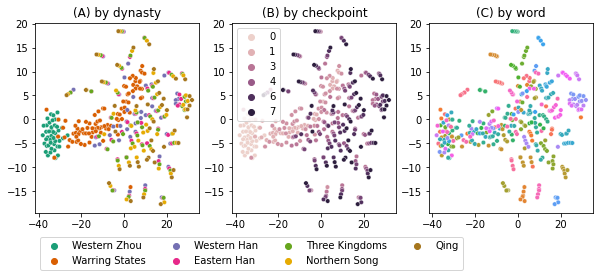

In [8]:
msize=20
fig = plt.figure(figsize=(10, 3.5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=dyns, palette="Dark2", s=msize)
plt.title("(A) by dynasty")
plt.legend(loc="upper left", ncol=4, bbox_to_anchor=(.0, -0.1))
plt.subplot(1, 3, 2)
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=ckpt_idxs, s=msize)
plt.title("(B) by checkpoint")
plt.legend(loc="upper left")
plt.subplot(1, 3, 3)
plt.title("(C) by word")
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=words, legend=False, s=msize)

fig.savefig("../data/10.00-trace-ckpt.png", dpi=200, bbox_inches="tight")


## Clustering

In [9]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward, fcluster, dendrogram, average, leaves_list
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
font_path = Path("NotoSansCJKtc-Medium.otf")


### Last checkpoints

In [11]:
def plot_cluster(mask, name):
    ckpt_vecs = wvecs[mask, :]
    dist = 1-cosine_similarity(ckpt_vecs)
    np.fill_diagonal(dist, 0)
    dist = squareform(dist)
    Z = average(dist)
    print("Leaves list: ", 
          [word_list[i] for i in leaves_list(Z)])
    cm_ax = sns.clustermap(squareform(dist), 
                           row_linkage=Z, col_linkage=Z, 
                           figsize=(6,6),
                           cmap="coolwarm_r")
    xlabels = cm_ax.ax_heatmap.get_xticklabels()
    word_labels = [word_list[int(x.get_text())] for x in xlabels]
    _ = cm_ax.ax_heatmap.set_xticklabels(word_labels, font=font_path, fontsize=12, rotation=0)
    _ = cm_ax.ax_heatmap.set_yticklabels(word_labels, font=font_path, fontsize=12, rotation=0)
    fig = cm_ax.fig
    fig.suptitle(f"Clustering of body words at the {name} checkpoint", y=1.02, fontsize=16)
    fig.savefig(f"../data/10.00-cluster-{name}.png", dpi=200, bbox_inches="tight")
    return f"../data/10.00-cluster-{name}.png"

Leaves list:  ['元', '領', '顏', '項', '心', '足', '耳', '眉', '目', '眼', '手', '背', '股', '額', '腰', '頰', '脊', '頸', '脰', '肘', '肩', '臂', '腳', '口', '嗌', '嚨', '喉', '咽', '齒', '唇', '舌', '膽', '腦', '腸', '胃', '肝', '脾', '肺', '腎', '胸', '腹', '牙', '面', '首', '頭']


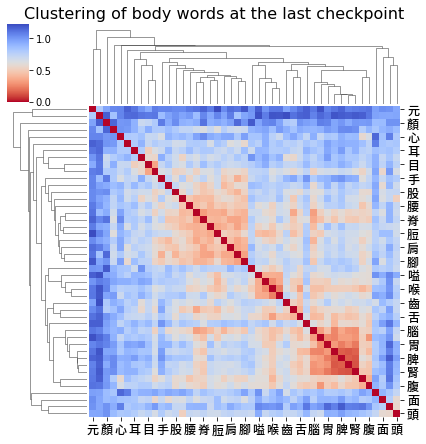

In [12]:
mask = np.nonzero(ckpt_idxs==7)[0]
clust_last_fpath = plot_cluster(mask, "last")

### First checkpoint

Leaves list:  ['領', '腸', '咽', '眉', '足', '額', '腹', '嗌', '腰', '顏', '肩', '頰', '脊', '口', '舌', '頭', '耳', '腳', '肝', '項', '股', '喉', '臂', '腦', '齒', '眼', '肘', '心', '首', '背', '元', '唇', '脾', '脰', '胸', '嚨', '手', '膽', '腎', '牙', '胃', '面', '頸', '目', '肺']


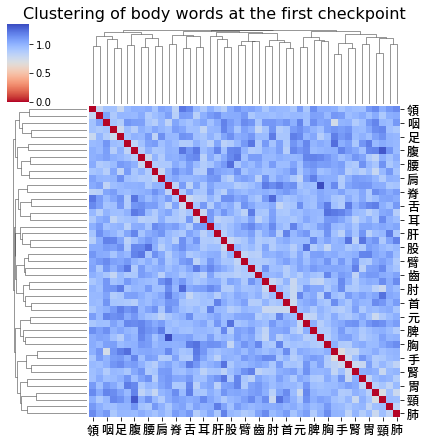

In [13]:
mask = np.nonzero(ckpt_idxs==0)[0]
clust_first_fpath = plot_cluster(mask, "first")

Leaves list:  ['嚨', '腦', '心', '足', '面', '額', '腳', '眼', '嗌', '目', '耳', '腰', '喉', '元', '首', '顏', '咽', '肘', '齒', '肩', '頭', '牙', '臂', '頰', '項', '胸', '股', '脾', '腎', '背', '肝', '領', '頸', '口', '眉', '手', '脰', '腹', '胃', '腸', '脊', '肺', '膽', '唇', '舌']


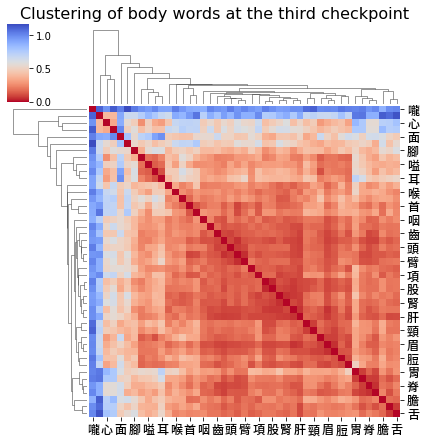

In [14]:
mask = np.nonzero(ckpt_idxs==2)[0]
clust_third_fpath = plot_cluster(mask, "third")

Leaves list:  ['元', '領', '首', '面', '足', '項', '背', '顏', '耳', '心', '目', '口', '肺', '肝', '脾', '腎', '胸', '腹', '胃', '腸', '眉', '齒', '牙', '臂', '頭', '頸', '舌', '肘', '腳', '腰', '肩', '脊', '額', '咽', '腦', '喉', '膽', '眼', '唇', '嚨', '頰', '脰', '嗌', '手', '股']


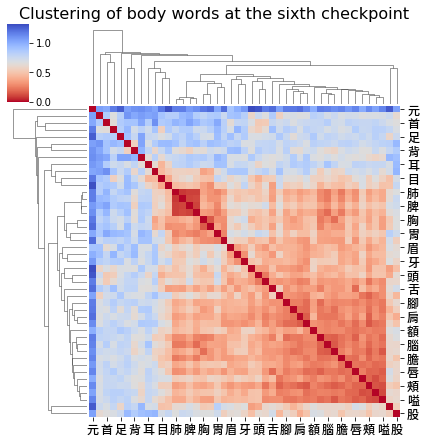

In [15]:
mask = np.nonzero(ckpt_idxs==5)[0]
clust_sixth_fpath = plot_cluster(mask, "sixth")

Leaves list:  ['元', '顏', '面', '領', '項', '心', '口', '肩', '股', '齒', '牙', '胸', '腹', '膽', '胃', '腸', '腦', '脾', '腎', '肺', '肝', '頸', '臂', '肘', '腰', '額', '腳', '頰', '脊', '唇', '嗌', '脰', '嚨', '咽', '舌', '喉', '目', '眉', '眼', '背', '首', '頭', '手', '耳', '足']


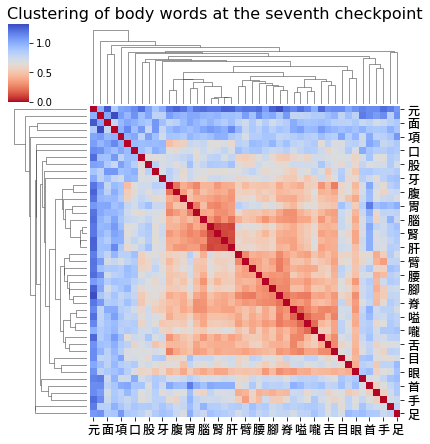

In [16]:
mask = np.nonzero(ckpt_idxs==6)[0]
clust_seventh_fpath = plot_cluster(mask, "seventh")

In [17]:
!sha1sum ../data/10.00*

db43f120c45a5f1e6ee9c78aa9d5d904c93c9ed2  ../data/10.00-cluster-first.png
97b5fa51d2ba0b7e4e57d1dc958097cefa87e689  ../data/10.00-cluster-last.png
d5705c83beabc86f98ad1e8ed4061b151986c34d  ../data/10.00-cluster-seventh.png
c365eb66200622cfd803594bcd0cd19d0f8b6bd6  ../data/10.00-cluster-sixth.png
d4005d37d5bc40e7ce17fde1411051968f8cfb68  ../data/10.00-cluster-third.png
a63c3214deba345f4190aa57b76f421d50588413  ../data/10.00-trace-ckpt.png
